# CMB Lensing and quadratic estimator tutorial 
_Louis Legrand, with some help from Julien Carron and Sebastian Belkner_

This notebook is a tutorial to generate a CMB map, lens it, and then estimate the lensing potential using a quadratic estimator. 
We will play a bit with **healpy** to generate CMB maps, and then we will use **lenspyx** to lens the maps and **plancklens** to estimate a QE, it's normalization and the spectrum biases.

The idea is to detail some of the steps that are performed inside the plancklens code.
This will give you an idea of a the standard pipeline for a CMB lensing analysis.

In [1]:
import os
import healpy as hp
import numpy as np
from os.path import join as opj

import matplotlib as mpl
from matplotlib import pyplot as plt

import lenspyx
import plancklens
from plancklens import utils
from plancklens import qest, qresp
from plancklens import nhl
from plancklens.n1 import n1
from plancklens.helpers.cachers import cacher_npy

In [2]:
# Maplotlib settings

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)

In [3]:
# Useful functions for plotting spectra

def f(ell):
    """To plot l(l+1)/2pi CMB spectra """
    return ell*(ell+1)/2/np.pi

def pp2kk(ell):
    """Convert Cl^{\phi, \phi} into Cl^{\kappa, \kappa}"""
    return (ell*(ell+1))**2/4



# 1 - Preliminary settings 

In [4]:
TEMP =  opj(os.environ['PLENS'], 'lensing_tutorial')
print(TEMP)
# Some things will be cached in this TEMP directory.
# plancklens uses hashckecks to raise errors when parameters are updated and do not match the data in cache 
# In this case it is safer to change the TEMP directory to be sure to not mess things around


/Users/louis/Code/plancklens/plens_write/lensing_tutorial


In [5]:
# We will generate random realisations of the CMB
# We set the numpy random seed to avoid recomputing the lensed maps whan restarting the notebook 

seed = 123456 # Choose your favorite number
np.random.seed(seed)

# We will save our map realisations in this TEMP directory 
cacher = cacher_npy(os.path.join(TEMP, f'seed_{seed}'))

# 2 - Generate the unlensed CMB maps and the lensing potential map

These CMB maps will be our primordial unlensed maps. They are not observable in practice because they will be lensed by the large scale structures. 
We will lens them with our lensing potential map. 

In [6]:
# Fiducial unlensed and lensed power spectra used for the simulations and for the analysis

cls_path = opj(os.path.dirname(os.path.abspath(plancklens.__file__)), 'data', 'cls')

cl_unl = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
cl_len = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lensedCls.dat'))

**Note:**  In a real life scenario, the real spectra of the CMB can be different from the fiducial ones used in the analysis. 
In a standard analysis we correct for this mismatch at a later stage by debiasing the reconstructed lensing power spectrum.
In our idealized simulation case we won't need that.

In [7]:
# This parameter set the maximum scale used to generate the CMB maps
lmax_sky = 6000

We use the **healpy** module and its **synalm** function. This function draws a random realization of the spherical harmonics (the $a_{\ell m}$'s) following the fiducial angular power spectra (the $C_\ell$'s). Indeed, for each $m$, the $a_{\ell m}$ follow a gaussian distribution of mean 0 and of variance $C_\ell$.

Here we generate three CMB maps, the temperature T and the E and B modes of polarizations. They are correlated and this is taken into account by providing the cross correlation spectrum $C_\ell^{TE}$. 
In standard cosmology with no parity violation, there is no cross correlation between the T and B nor the T and E. 
Moreover in our simulation we do not include primordial B modes (due to gravitational waves generated during inflation), so $C_\ell^{BB} = 0$

Because we want to be fancy here, we take into account the correlation between the temperature and the E modes with the lensing potential $\phi$. This correlation is mainly on large scales and comes from the iSW effect. 
So we generate altogether these 4 fields: T, E, B (which is zero) and $\phi$. 

In [8]:
alms_arr = hp.synalm([cl_unl['tt'], cl_unl['te'], None, cl_unl['pt'], 
    cl_unl['ee'], None, cl_unl['pe'], cl_unl['bb'], None, cl_unl['pp'] ], new=False, lmax=lmax_sky)


In [9]:
alms = {'t':alms_arr[0], 'e':alms_arr[1], 'b':alms_arr[2], 'p':alms_arr[3]}

**Note:** We generated spherical harmonics coefficients. 
To plot them in the real space on the sphere, we use the healpix pixelisation scheme, which is implemented in **healpy**. 

Let's have a look at the map we generated:

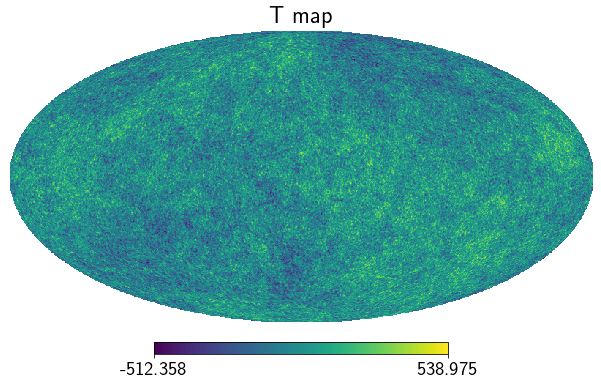

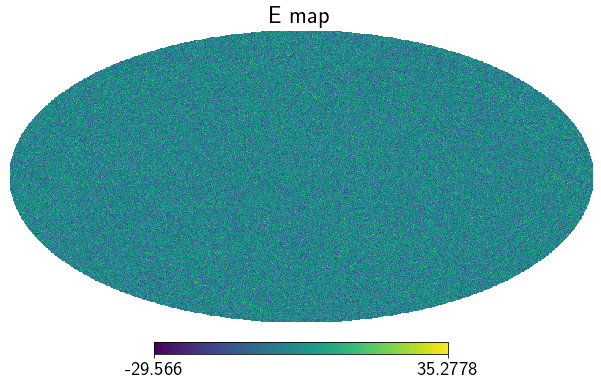

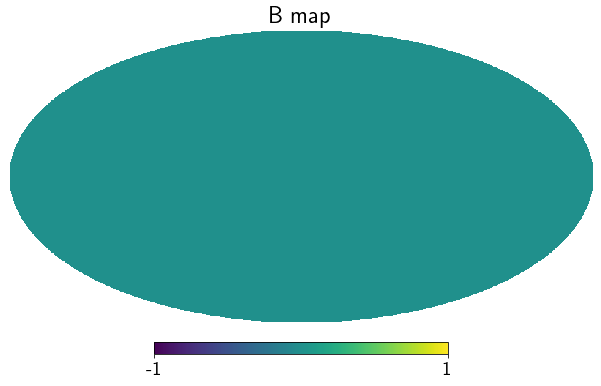

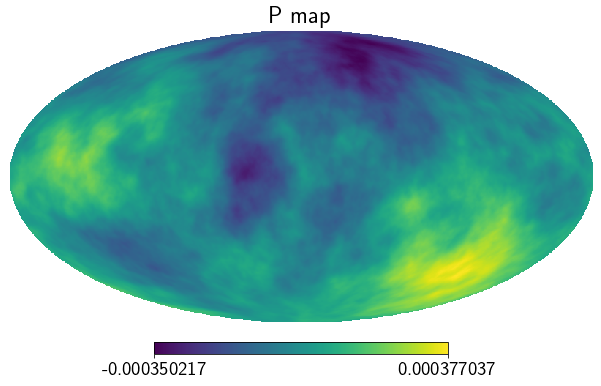

In [10]:
for k in ['t', 'e', 'b', 'p']:
    hp.mollview(hp.alm2map(alms[k], nside=1024), title=f'{k.upper()} map')

Let's check how the spectra of these map looks like, and if they follow the input spectra we used.

We estimate the pseudo Cl's by 

$$\hat C_\ell^{XY} = \frac{1}{2\ell+1}\sum_{m=-\ell}^{\ell} X_{\ell m} Y^*_{\ell m}$$

Text(0, 0.5, '$ \\ell(\\ell+1)/ 2\\pi \\; C_\\ell $')

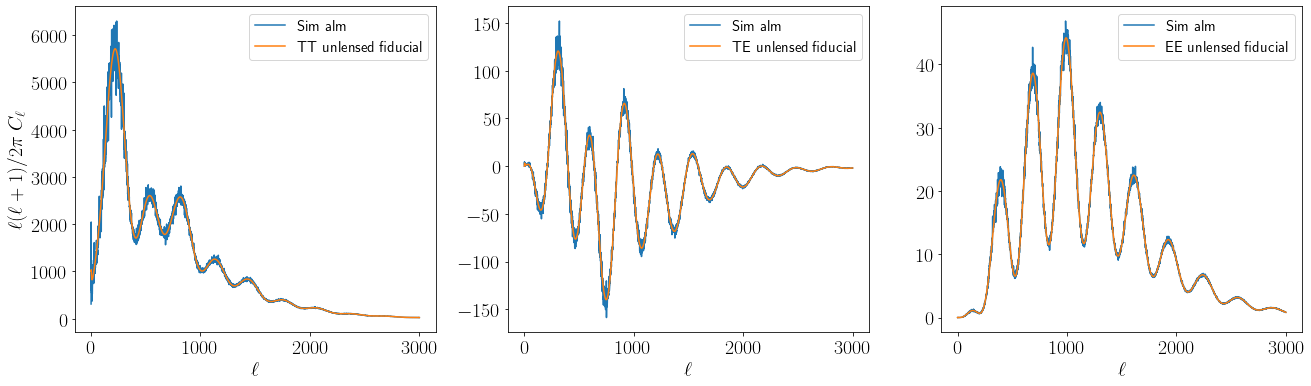

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(22, 6))

ell = np.arange(1, 3000)

for ax, (x, y) in zip(axs.flatten(), ['tt', 'te', 'ee']):
    ax.plot(ell, f(ell)*hp.alm2cl(alms[x], alms[y])[ell], label='Sim alm')
    ax.plot(ell, f(ell)*cl_unl[x+y][ell], label=f'{(x+y).upper()} unlensed fiducial')
    ax.set_xlabel(r'$\ell$')
    ax.legend()
axs[0].set_ylabel(r'$ \ell(\ell+1)/ 2\pi \; C_\ell $')
    # ax.set_xscale('log')

Text(0, 0.5, '$ \\ell^3 \\; C_\\ell $')

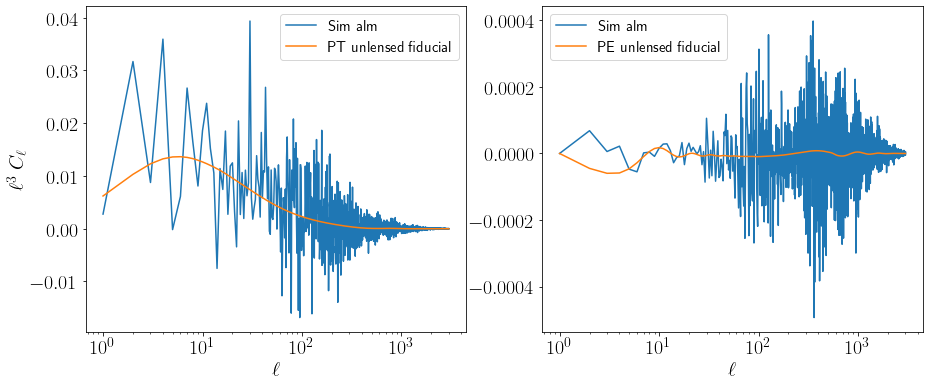

In [40]:

# ell = np.arange(1, 3000)
# fig, axs = plt.subplots(1, 1, figsize=(6, 6))
# for ax, (x, y) in zip(axs, ['pp']):
#     ax.plot(ell, pp2kk(ell)*hp.alm2cl(alms[x], alms[y])[ell], label='Sim alm')
#     ax.plot(ell, pp2kk(ell)*cl_unl[x+y][ell], label=f'{(x+y).upper()} unlensed fiducial')
#     ax.set_xlabel(r'$\ell$')
#     ax.set_ylabel(r'$ (\ell(\ell+1))^2/ 4 \; C_\ell $')
#     ax.legend()
#     ax.set_xscale('log')

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

for ax, (x, y) in zip(axs.flatten(), ['pt', 'pe']):
    ax.plot(ell, ell**3*hp.alm2cl(alms[x], alms[y])[ell], label='Sim alm')
    ax.plot(ell, ell**3*cl_unl[x+y][ell], label=f'{(x+y).upper()} unlensed fiducial')
    ax.set_xlabel(r'$\ell$')
    ax.legend()
    ax.set_xscale('log')
axs[0].set_ylabel(r'$ \ell^3 \; C_\ell $')

# 3 - Lens the CMB maps

We will use the **lenspyx** package to lens the CMB maps we generated.

The lensing operation is defined by 

$$X^{len}(\bold{\hat n}) = X^{unl}(\bold{\hat n} + \bold{d}(\bold{\hat n})) $$ 

Where $X\in[T, Q, U]$ and the deflection vector field $\bold{d}$ is defined as $\bold{d} = \nabla \phi$. 
We will also use the convergence field $\kappa = -\frac{1}{2} \Delta \phi$.


In practice, the lensing operation defined above is applied as a remapping of the unlensed CMB field. This is done in **lenspyx** by interpolation the grid and remapping the pixels of the map.


In [13]:
# parameters which impact of the accuracy of the result (and the execution time):

lmax_out = 2048  # desired lmax of the lensed field.
nside_lens = 2048 # The lensed tlm's are computed with healpy map2alm from a lensed map at resolution 'nside_lens'
facres = -1 # The lensed map of resolution is interpolated from a default high-res grid with about 0.7 amin-resolution
            # The resolution is changed by 2 ** facres is this is set.

We first transform the lensing potential field into a spin-1 deflection field. 

In [14]:
dlm = hp.almxfl(alms['p'], np.sqrt(np.arange(lmax_out + 1, dtype=float) * np.arange(1, lmax_out + 2)))

We now deflect the temperature map. Lenspyx deflect the temperature field at the map level, so the output is an healpix map with nside = nside_lens.
The result of the lensing operation is cached to avoid recomputing it the next time. |


**Note:** We now focus on the temperature filed only, but as an exercise you can do the same on the polarisation fields, and reconstruct the lensing potential with the full T, E and B fields. You will see that the lensing creates B mode signal.

In [15]:
fn_tlens = 'tmap_len'

if not cacher.is_cached(fn_tlens):
    Tlen  = lenspyx.alm2lenmap(alms['t'], [dlm, None], nside_lens, facres=facres)
    cacher.cache(fn_tlens, Tlen)
Tlen = cacher.load(fn_tlens)

Let's compare the lensed map we generated with the unlensed one. 

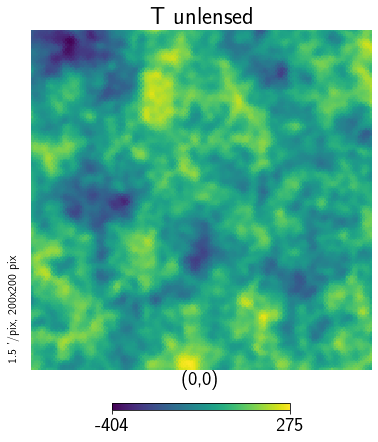

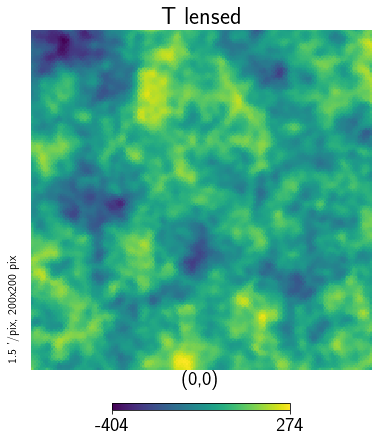

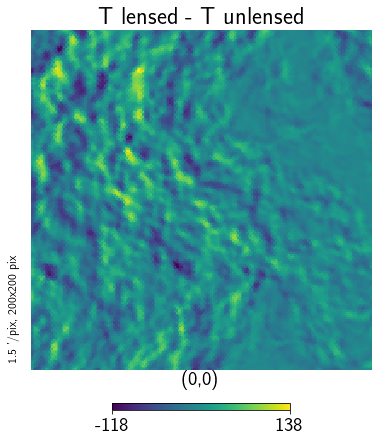

In [16]:
hp.gnomview(hp.alm2map(alms['t'], nside=nside_lens), title='T unlensed')
hp.gnomview(Tlen, title='T lensed')
hp.gnomview(Tlen- hp.alm2map(alms['t'], nside=nside_lens), title='T lensed - T unlensed')



We can compare the lensed map we generated with the fiducial lensed power spectrum 

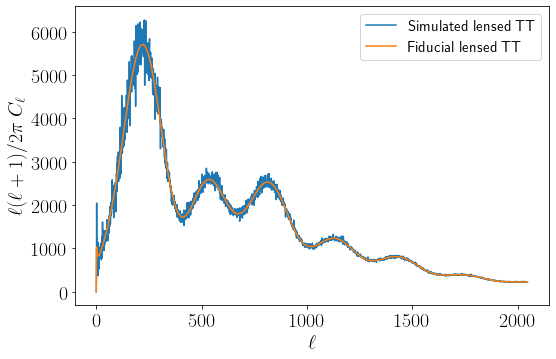

In [17]:
ell = np.arange(2048)

plt.plot(ell, f(ell)*hp.anafast(Tlen, lmax=ell[-1], iter=0), label='Simulated lensed TT')
plt.plot(ell, f(ell)*cl_len['tt'][ell], label='Fiducial lensed TT')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$ \ell(\ell+1)/ 2\pi \; C_\ell $')
plt.legend()


# 4- Beam and noise


We now simulate observed CMB maps by convolving the lensed maps with a gaussian beam (resolution of our instrument) and adding a white noise.

In [18]:
nlev_t = 5.  #Temperature noeise level in muK.arcmin
nlev_p = 5*np.sqrt(2.) #Polarisation noeise level in muK.arcmin (we wont use it here)

beam_fwhm_amin = 3. # Full width at half maximum of the gaussian beam of our instrument, in arcmin

lmax_ivf = 2048 
lmin_ivf = 10
# We will not the use the CMB modes outside of this interval
# IVF means inverse variance filter, this is an input of our quadratic estimator 


We generate the noise alm's with flat spectrum with variance given by nlev_t

In [19]:
noise_lm = hp.synalm(np.ones(lmax_ivf+1)*(nlev_t*np.pi /180/60)**2)

In [20]:
# We could also generate the noise at the pixel level (ie in real space) 
# pixel angle in arcmin 
# vamin = np.sqrt(hp.nside2pixarea(nside, degrees=True)) * 60
# std_per_pizel = nlev_t/vamin
# npix = hp.nside2npix(nside)
# Tnoise = np.random.standard_normal(npix) * std_per_pizel
# cl_tnoise = hp.anafast(Tnoise, lmax=lmax_ivf, iter=1)

Check it's working 

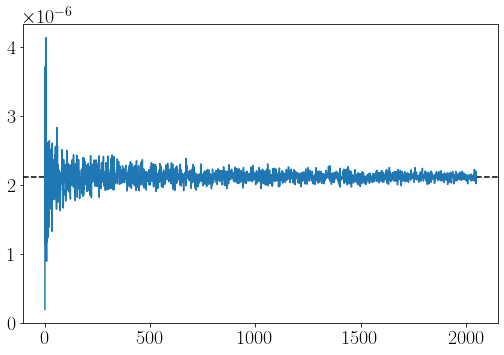

In [21]:
ell = np.arange(lmax_ivf+1)

plt.axhline(y=(nlev_t*np.pi /180/60)**2, c='k', ls='--')

plt.plot(ell, hp.alm2cl(noise_lm)[ell])

We now convolve the map with a beam and add the noise

In [22]:
cl_beam = hp.gauss_beam(fwhm=beam_fwhm_amin*np.pi/180/60, lmax=lmax_ivf)


In [23]:
tlm = hp.map2alm(Tlen, iter=3, lmax=lmax_ivf)
hp.almxfl(tlm, cl_beam, inplace=True)


tobs_lm = tlm + noise_lm
# This is our observed temperature map

# 5 - Estimate the lensing potential field


Finally ! 
Now that we have an observed temperature map, we can define a QE to reconstruct the lensing on this map.

Let us recall that the lensing creates correlations between different scales. This can be described by: 

$$<X(\bold{l}_1)Y(\bold{l}_2)>_{\mathrm{fixed} \, \phi} = f_{XY}(\bold{l}_1, \bold{l}_2) \phi(\bold{L})$$
for $\bold{l}_1 \neq \bold{l}_2$ and  $\bold{L} = \bold{l}_1 + \bold{l}_2$. This $f_{XY}$ function describes the coupling between the different scales which is created by lensing. 
For temperature only it is given by (see e.g. Manyiar et al. 2021)
$$f_{TT}(\bold{l}_1, \bold{l}_2) =  C_{l_1}^{TT} (\bold{L}\cdot \bold{l}_1) + C_{l_2}^{TT} (\bold{L}\cdot \bold{l}_2) $$
where the $C_{l}^{TT}$ are the lensed CMB spectra (a more optimal estimator can be defined with the grad-lensed Cls).


In practice we only have one realization of the CMB, so we can not average over it to get the value of $\phi$. The best we can do is to define an estimator of $\phi$, which we will make sure to be unbiased, and to have the minimum variance.
This estimator will combines of CMB fields (hence quadratic estimator) and was introduced in Hu and Okamoto 2002

$$ \hat \phi_{XY}(\bold{L}) = \frac{1}{R_{XY}(\bold{L})} \int_{\bold{L}=\bold{l}_1 + \bold{l}_2} \bar{X}_{\bold{l}_1} \bar{Y}_{\bold{l}_2} f_{XY}(\bold{l}_1, \bold{l}_2) \; ,$$
with $\bar{X}$ and $\bar{Y}$ the inverse variance filtered CMB fields and $R_{XY}(\bold{L})$ the normalization which makes the estimator unbiased, i.e. $<\hat \phi_{XY}>_{\mathrm{fixed} \, \phi} = \phi$


Let us now implement this estimator using the **plancklens** package. 

We start by defining the inverse variance filters of the temperature map $$\mathrm{filt}(l) = \frac{1}{ C_{}^{TT} + N_l^{TT}}$$
with $  N_l^{TT}$ the noise spectrum of the map.

In [24]:
cl_transf = cl_beam 
# The transfer function of our maps is the beam of the instrument
# In some configurations we should also take into account the pixel window function (given by hp.pixwin(nside_lens)), but we do not need it here 
# (in our simulations the pixel value is the value at the center of the pixel and not the average of the CMB inside the pixel).

ftl = utils.cli(cl_len['tt'][:lmax_ivf + 1] + (nlev_t / 60. / 180. * np.pi / cl_transf) ** 2)
ftl[:lmin_ivf] *= 0.
# This is the inverse variance filter
# It also sets the minimum and maximum scales of the CMB maps used in the reconstruction 


def get_alm_ivfs(x):
    """The eval_qe function of plancklens ask for a callable to access the filtered CMB maps"""
    if x =='t':
        return hp.almxfl(tobs_lm, ftl* utils.cli(cl_transf[:lmax_ivf+1]))
    else:
        return 0

We now define our estimator. 
The weights below are the Cls that are used in the function $f_{XY}$ of the estimator.

In [25]:
# We want to reconstruct the lensing potential field up to this lmax
lmax_qlm = 2048

In [26]:
cls_weight = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))


The function below performs the quadratic estimation. 
The glm and the clm are respectively the gradient and the curl modes of the defelection field. 
In current CMB surveys, the curl modes are unobservable so they are often used as a consistency check. In our simulation they should be zero.


In [27]:
fn_glm = 'glm'
fn_clm = 'clm'

if not cacher.is_cached(fn_glm) or not cacher.is_cached(fn_clm):
    glm, clm = qest.eval_qe('ptt', lmax_ivf, cls_weight, get_alm_ivfs, nside=4096, lmax_qlm=lmax_qlm, verbose=True)
    cacher.cache(fn_glm, glm)
    cacher.cache(fn_clm, clm)
glm = cacher.load(fn_glm)
clm = cacher.load(fn_clm)


The functions below define the the response of the estimator, which is used to normalise $\hat \phi$

In [28]:
#---- QE response calculation library:
qresp_dd = qresp.resp_lib_simple(os.path.join(TEMP, 'qresp'), lmax_ivf, cls_weight, cl_len,
                                 {'t': ftl}, lmax_qlm)

# Lensing response according to the fiducial cosmology:t
resp = qresp_dd.get_response('ptt', 'p')


# Estimator normalization is the inverse response:
qnorm = utils.cli(resp)                               

Let us now compare our estimated $\hat \phi$ with the input $\phi$ of our simulation !

In [29]:
plm_input = utils.alm_copy(alms['p'], lmax=lmax_qlm)

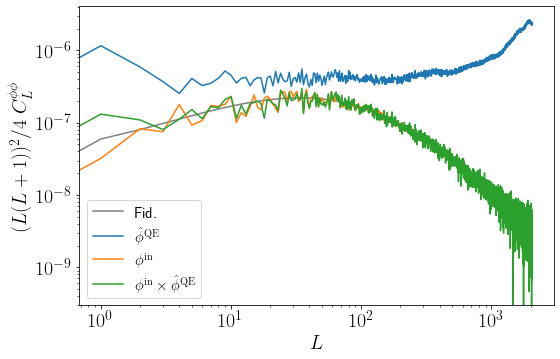

In [30]:
plt.plot(ell, pp2kk(ell) * cl_unl['pp'][ell], label='Fid.', c='grey')

plt.plot(ell, pp2kk(ell) * hp.alm2cl(glm)[ell]  * qnorm[ell] ** 2, label='$\hat \phi^\mathrm{QE}$')


plt.plot(ell, pp2kk(ell) * hp.alm2cl(plm_input)[ell], label='$\phi^\mathrm{in}$')


plt.plot(ell, pp2kk(ell) * hp.alm2cl(glm, plm_input)[ell] *qnorm[ell], label='$\phi^\mathrm{in} \\times \hat \phi^\mathrm{QE}$')

plt.loglog()


plt.xlabel(r'$L$')
plt.ylabel(r'$ (L(L+1))^2/ 4 \; C_L^{\phi \phi} $') 

plt.legend()

# 6 - Debiasing the QE spectrum 

As you can see above, the auto spectrum of the $\hat \phi$ seems to be totally biased. This is due to the fact that the QE will take all correlations between different CMB scales as due to lensing. However in the random field of teh CMB we have random correlations between different scales (even if it is zero on average).
This is known as the $N_L^{(0)}$ bias, and it can be estimated analytically.

We use plancklens to get an estimate of this N0.


In [31]:
N0s =  nhl.get_nhl('ptt', 'ptt', cls_weight, {'tt':ftl}, lmax_ivf, lmax_ivf )

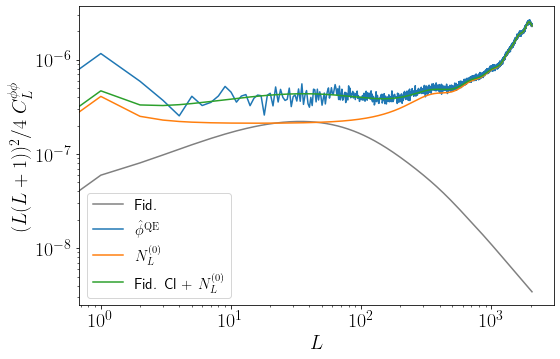

In [32]:

plt.plot(ell, pp2kk(ell) * cl_unl['pp'][ell], label='Fid.', c='grey')

plt.plot(ell, pp2kk(ell) * hp.alm2cl(glm)[ell]  * qnorm[ell] ** 2, label='$\hat \phi^\mathrm{QE}$')

plt.plot(ell, pp2kk(ell)*N0s[0][ell]* qnorm[ell] ** 2., label='$N_L^{(0)}$')


# plt.plot(ell, pp2kk(ell) * (hp.alm2cl(glm)[ell] -N0s[0][ell]) * qnorm[ell] ** 2, label='$\hat \phi^\mathrm{QE} - N_L^{(0)}$')

plt.plot(ell, pp2kk(ell) * (cl_unl['pp'][ell] + N0s[0][ell]* qnorm[ell] ** 2), label='Fid. Cl + $N_L^{(0)}$')


plt.loglog()


plt.xlabel(r'$L$')
plt.ylabel(r'$ (L(L+1))^2/ 4 \; C_L^{\phi \phi} $') 

plt.legend()

We now have an estimator of the lensing power spectrum which can be debiased. 

There are higher order bias terms, such as $N_L^{(1)}$ due to CMB correlations which are created by lensing, or $N_L^{(3/2)}$ which arise due to the non gaussianity of the LSS. 

To perform a realistic analysis we would have to take into account the mask of the survey. This creates also a signal in the QE which is called the mean field, it is the response of the QE to the mask. We can estimate it using simulations of the experiment, and subtract it from our $\hat \phi$ estimate. 

All the ingredients we put in the lensing reconstruction are fiducial ones: in practice we don't know exactly the CMB spectra, nor the beam or the noise level of our instrument. 
This is taken into account in a realization dependant debiaser. 

# 7 - Realization dependant debiaser 

Let's use the same simulation with the same fiducial spectra, but reconstruct the lensing potential with a QE using biased fiducial ingredients.

Using the biased ingredients to estimate the N0 bias will get us a biased estimate of teh power spectrum. 
But we can use a realization dependant debiaser, which combines the true spectra of the map with the biased fiducials. We can show that this debiased is robust in the mismatch between the data and the fiducial assumptions.


We will assume that the CMB Cls are 10 % lower than the true Cls.
This would be a huge mismatch because CMB Cls are known at much better than 10%.


In [33]:
bias = 0.9

cl_biased = {}
for k in ['tt', 'te', 'ee']:
    cl_biased[k] = cl_len[k] * bias


ftl_b = utils.cli(cl_biased['tt'][:lmax_ivf + 1] + (nlev_t / 60. / 180. * np.pi / cl_transf) ** 2)
ftl_b[:lmin_ivf] *= 0.
# This is the inverse variance filter
# It also sets the minimum and maximum scales of the CMB maps used in the reconstruction 


def get_alm_ivfs_b(x):
    """The eval_qe function of plancklens ask for a callable to access the filtered CMB maps"""
    if x =='t':
        return hp.almxfl(tobs_lm, ftl_b* utils.cli(cl_transf[:lmax_ivf+1]))
    else:
        return 0


glm_b, _ = qest.eval_qe('ptt', lmax_ivf, cl_biased, get_alm_ivfs_b, nside=4096, lmax_qlm=lmax_qlm, verbose=True)


QE 1 out of 1 :
in-spins 1st leg and out-spin [0] 0
in-spins 2nd leg and out-spin [0] 1


In [34]:
#---- QE response calculation library:
qresp_dd = qresp.resp_lib_simple(os.path.join(TEMP, 'qresp_b' +str(bias)), lmax_ivf, cl_biased, cl_biased,
                                 {'t': ftl_b}, lmax_qlm)

# Lensing response according to the fiducial cosmology:t
resp = qresp_dd.get_response('ptt', 'p')


# Estimator normalization is the inverse response:
qnorm = utils.cli(resp)  

In [35]:
N0s =  nhl.get_nhl('ptt', 'ptt', cl_biased, {'tt':ftl_b}, lmax_ivf, lmax_ivf )

# We use a semi analytical RD-N0 debiaser, using the IVF data spectrum in the N0 estimate 
RDN0s =  nhl.get_nhl('ptt', 'ptt', cl_biased, {'tt': hp.alm2cl(get_alm_ivfs_b('t'))}, lmax_ivf, lmax_ivf )

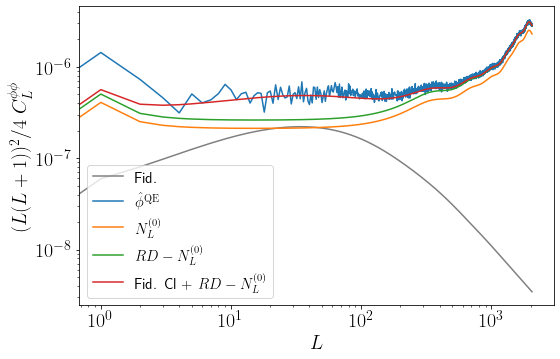

In [36]:

plt.plot(ell, pp2kk(ell) * cl_unl['pp'][ell], label='Fid.', c='grey')

plt.plot(ell, pp2kk(ell) * hp.alm2cl(glm_b)[ell]  * qnorm[ell] ** 2, label='$\hat \phi^\mathrm{QE}$')

plt.plot(ell, pp2kk(ell)*N0s[0][ell]* qnorm[ell] ** 2., label='$N_L^{(0)}$')
plt.plot(ell, pp2kk(ell)*RDN0s[0][ell]* qnorm[ell]**2, label='$RD-N_L^{(0)}$')



plt.plot(ell, pp2kk(ell) * (cl_unl['pp'][ell] + RDN0s[0][ell]* qnorm[ell] ** 2), label='Fid. Cl + $RD-N_L^{(0)}$')


plt.loglog()


plt.xlabel(r'$L$')
plt.ylabel(r'$ (L(L+1))^2/ 4 \; C_L^{\phi \phi} $') 

plt.legend()